# Census Income (Adult UCI Dataset)

The Census Income dataset, also knows as Adult UCI has been extracted by Barry Becker from the 1994 Census dataset and is used to train predictors with the task of determining
whether a person makes over $50,000 a year. In this notebook, we will use `fairlens` to analyze the Census Income dataset for bias against a protected group. We will then explore
how such biases might affect a predictor trained on this dataset.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import fairlens as fl
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier

# Load in the Census data
df = pd.read_csv("../datasets/adult.csv")
df

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


## Preprocessing

We will drop rows that contain unknown or missing values and only analyze the remaining dataset.

In [2]:
df.replace("?", np.nan, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45217,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
45218,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
45219,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
45220,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


## Analysis

Firstly, we need to scan the dataset in order to identify columns containing sensitive or legally protected information, which will then be used for checking the presence of bias.
Using a configuration based on the UK Government's legislation regarding protected groups, and the method `fairlens.sensitive.detect_names_df`, we can automatically discover these
hidden series.

Sometimes the column name itself might not be indicative of whether its content is sensitive. As such, we set the `deep_search` flag to true to ensure that we also look at samples
from each series and try to match them against our possible values from the loaded configuration.

In [3]:
sensitive_attributes = fl.sensitive.detect_names_df(df, deep_search=True)
print(sensitive_attributes)

{'age': 'Age', 'marital-status': 'Family Status', 'race': 'Ethnicity', 'gender': 'Gender', 'relationship': 'Family Status'}


We have now discovered that there are a considerable number of columns that have been matched with sensitive categories from our configuration (age, family status, race, gender). In this case, both `relationship` and `marital-status` have been associated with `Family Status`, which is comprehensive enough to represent both.

In [4]:
df[["age", "marital-status", "race", "gender", "relationship"]].head()

,age,marital-status,race,gender,relationship
0,25,Never-married,Black,Male,Own-child
1,38,Married-civ-spouse,White,Male,Husband
2,28,Married-civ-spouse,White,Male,Husband
3,44,Married-civ-spouse,Black,Male,Husband
4,34,Never-married,White,Male,Not-in-family


Let us now go on and inspect the distributions of all the sub-groups of the sensitive columns (as well as that of the entire population) with respect to the target column of interest,
which, in this case, is `income`. We will do this by using various methods from `fl.plot`, which automatically pick out the best visual representation based on the type of the target
series (i.e. categorical, binary, continuous).

Notice that four out of the five sensitive attributes are categorical, while only `age` is continuous. However, this is not a problem, because `age` will automatically be binned and discretized
during plotting.

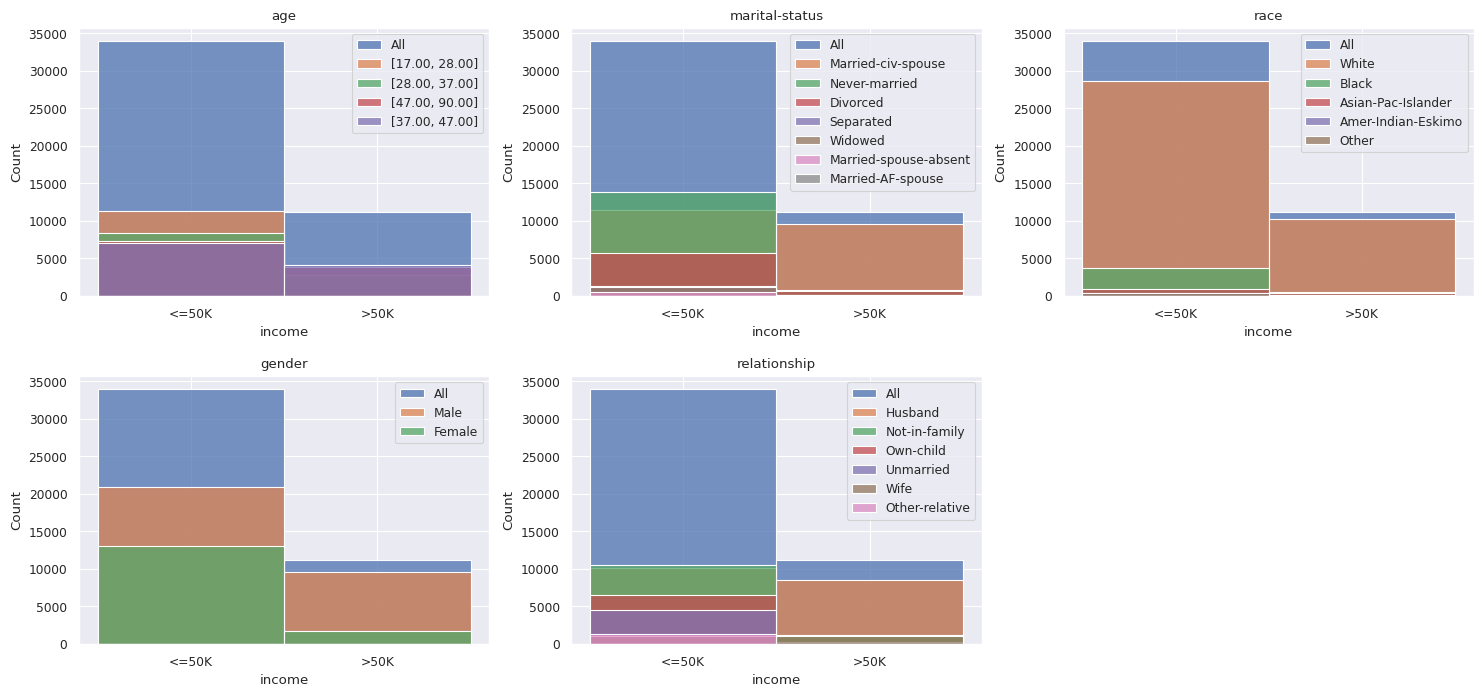

In [10]:
target_attribute = "income"
sensitive_attributes = ["age", "marital-status", "race", "gender", "relationship"]

# Set the seaborn style
fl.plot.use_style()

# Plot the distributions
fl.plot.mult_distr_plot(df, target_attribute, sensitive_attributes, max_quantiles=4)
plt.show()

While there are many discrepancies that can be observed, the easiest to notice is that of the `gender` column, as the ratio between women who earn <=50k and >50k is much larger than the same
ratio computed for men.

Additionally, by looking at the diagram for `marital-status`, we can notice that the `Married-civ-spouse` sub-group clearly dominates other sub-categories such as `divorced`, `never-married` or
`widowed`, though this might not necessarily imply the existence of an intrinsic bias, but rather be a consequence of a number of behavioural or socioeconomic factors. 

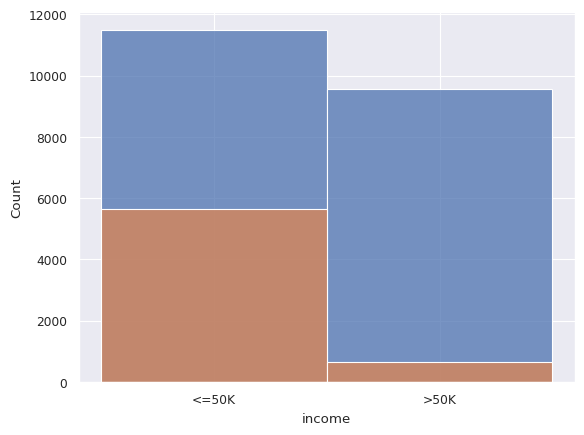

In [11]:
# Select specific sub-groups from a sensitive column to look at.
group1 = {"marital-status": ["Married-civ-spouse"]}
group2 = {"marital-status": ["Divorced"]}

# Plot the sub-group distributions with respect to a target.
fl.plot.distr_plot(df, target_attribute, [group1, group2])
plt.show()

After visually inspecting the sensitive group distributions and possibly noticing some that might contain bias, we can move on to numerically quantify the statistical distance present
between the distributions. To do this, a number of metrics that are already implemented (or that can be added by users) are usable and since the target `income` is categorical (and binary
even), we can employ metrics such as Earth Mover's Distance, LP-Norm and Hellinger Distance. 

Moreover, the function `stat_distance` from `fairlens.metrics` can be used to automatically pick a best default metric for the task at hand, but setting a `mode` for it will use the matching
distance method.

In [12]:
import fairlens.metrics as fm

group1 = {"gender": ["Male"]}
group2 = {"gender": ["Female"]}

distances = {}
for metric in ["emd", "norm", "hellinger"]:
    distances[metric] = fm.stat_distance(df, "income", group1, group2, mode=metric)
pd.DataFrame.from_dict(distances, orient="index", columns=["distance"])

,distance
emd,0.198901
norm,0.281289
hellinger,0.175921


Usually, to check whether a certain sub-group from a protected category (i.e. sub-group `Female` from category `gender`) presents a bias from the rest of the population, we can calculate the
statistical distance between the distribution of the whole population and that of the sub-group of interest, with respect to the critical target column. Using the streamlined `fl.FairnessScorer`
class, we can pass a dataframe and a target (and optionally the sensitive attributes, which are inferred otherwise) and its method `distribution_score`, we can quickly generate a report of the
most biased sub-groups from our data, along with respective counts and a `p-value` for each entry, indicating the significance of the observed differences through suitable hypothesis tests.

In [13]:
fscorer = fl.FairnessScorer(df, "income", ["gender", "race", "marital-status"])
fscorer.distribution_score(max_comb=1, p_value=True)

,Group,Distance,Proportion,Counts,P-Value
0,Male,0.064634,0.675048,30527,2.740078e-143
1,Female,-0.134268,0.324952,14695,4.940656e-324
2,Never-married,-0.199824,0.322807,14598,4.940656e-324
3,Married-civ-spouse,0.206395,0.465592,21055,4.940656e-324
4,Widowed,-0.153091,0.028238,1277,4.009320e-44
5,Separated,-0.177681,0.031202,1411,3.137759e-68
6,Divorced,-0.143826,0.139246,6297,7.037394e-184
7,Married-spouse-absent,-0.150018,0.012206,552,5.150940e-19
8,Married-AF-spouse,0.189656,0.000708,32,2.190622e-02
9,Black,-0.121543,0.093494,4228,7.705932e-86


## Training a Model

Now that our analysis using `fairlens` has proven the presence of some intrinsic bias in the dataset, we can train a model on it to check if it propagates the bias and affects its predictions
through learned prejudice.

To do this, we will use a `RandomForestClassifier` from `sklearn`, as it seems to produce the best accuracies for this specific dataset.

Accuracy: 0.9998341487685546


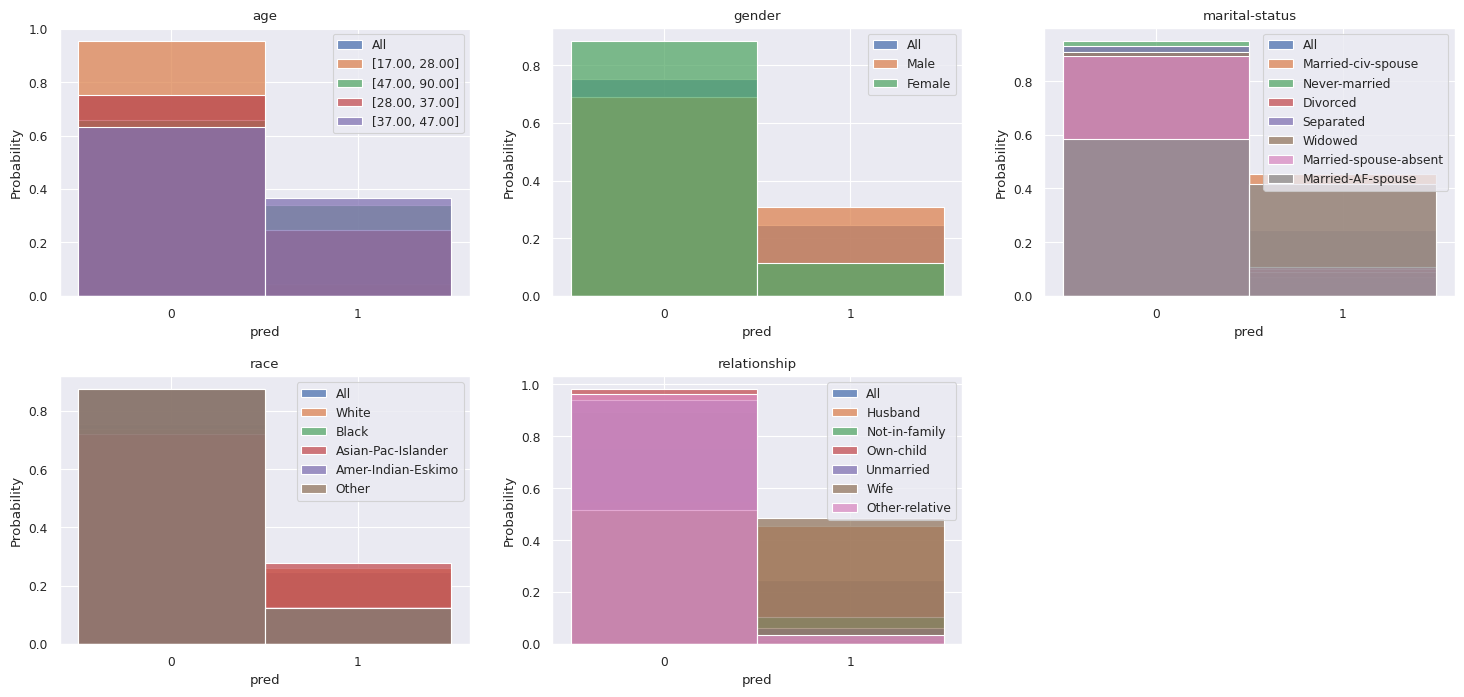

In [14]:
# Select the features to use
df = df[["age", "workclass", "fnlwgt", "educational-num", "marital-status", "occupation", "relationship", 
    "race", "gender", "capital-gain", "capital-loss", "hours-per-week", "income"]]

# Split the dataset into train and test
sp = int(len(df) * 0.8)
df_train = df[:sp].reset_index(drop=True)
df_test = df[sp:].reset_index(drop=True)

# Convert categorical columns to numerical columns
def preprocess(df):
    X = df.copy()

    for col in ["workclass", "marital-status", "occupation", "relationship", "race", "gender"]:
        X[col] = pd.factorize(X[col])[0]

    X.drop(columns=["income"], inplace=True)
    X = X.to_numpy()

    y = df["income"].replace(["<=50K", ">50K"], [0, 1])

    return X, y

X, y = preprocess(df_train)

# Train a classifier
clf = RandomForestClassifier().fit(X, y)

# Classify the training data and print accuracy
y_pred = clf.predict(X)
print(f"Accuracy: {np.mean(y_pred == y)}")

df_train["pred"] = clf.predict(X)

# Plot the distributions
fscorer = fl.FairnessScorer(df_train, "pred", ["age", "marital-status", "race", "gender", "relationship"])
fscorer.plot_distributions(max_quantiles=4, normalize=True)
plt.show()